训练模型、评估模型

主要得到：

训练好的模型、模型评估结果

# 读取数据和引入模块

In [1]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
import toad

In [2]:
data_train = pd.read_csv('data_train.csv')
data_train = data_train.iloc[:,1:]

In [3]:
X_train = data_train.drop(columns = ['loan_status'])
y_train = data_train['loan_status']

In [4]:
X_train.shape,y_train.shape

((26313, 19), (26313,))

In [5]:
y_train.value_counts()

0    19016
1     7297
Name: loan_status, dtype: int64

In [6]:
data_test = pd.read_csv('data_test.csv')
data_test = data_test.iloc[:,1:]

In [7]:
X_test = data_test.drop(columns = ['loan_status'])
y_test = data_test['loan_status']

In [8]:
X_test.shape,y_test.shape

((6579, 19), (6579,))

In [9]:
y_test.value_counts()

0    4777
1    1802
Name: loan_status, dtype: int64

# 模型训练

## 网格搜索

In [10]:
'''param={'n_estimators':list(range(50, 400, 50)),'max_depth':list(range(2, 5, 1)),'learning_rate':list(np.arange(0.01, 0.5, 0.05))}
gridsearch=sk.model_selection.GridSearchCV(estimator=sk.ensemble.GradientBoostingClassifier(subsample=0.8,validation_fraction=0.1,n_iter_no_change=3,random_state=1),
                                          param_grid=param,cv=3,scoring='f1',n_jobs=-1,verbose=2)
gridsearch.fit(X_train,y_train)
gridsearch.best_params_,gridsearch.best_score_'''

"param={'n_estimators':list(range(50, 400, 50)),'max_depth':list(range(2, 5, 1)),'learning_rate':list(np.arange(0.01, 0.5, 0.05))}\ngridsearch=sk.model_selection.GridSearchCV(estimator=sk.ensemble.GradientBoostingClassifier(subsample=0.8,validation_fraction=0.1,n_iter_no_change=3,random_state=1),\n                                          param_grid=param,cv=3,scoring='f1',n_jobs=-1,verbose=2)\ngridsearch.fit(X_train,y_train)\ngridsearch.best_params_,gridsearch.best_score_"

## 训练模型

In [11]:
GBDT_model=sk.ensemble.GradientBoostingClassifier(subsample=0.8,validation_fraction=0.1,n_iter_no_change=3,random_state=1,max_depth=4,n_estimators=50,learning_rate=0.46)
GBDT_model_fit=GBDT_model.fit(X_train,y_train)

## 预测与评估

### 混淆矩阵

In [12]:
y_pred_test = GBDT_model_fit.predict(X_test)
y_pred_train = GBDT_model_fit.predict(X_train)
cnf_matrix = sk.metrics.confusion_matrix(y_test,y_pred_test)
cnf_matrix = pd.DataFrame(cnf_matrix,index = ["标签为好","标签为坏"],columns = ['预测为好','预测为坏'])
cnf_matrix

预测为好  预测为坏
标签为好  4459   318
标签为坏  1457   345

### 评估指标

In [13]:
accuracy=sk.metrics.accuracy_score(y_test,y_pred_test)
y_score=GBDT_model_fit.predict_proba(X_test)[:,1]
auc=sk.metrics.roc_auc_score(y_test,y_score)
fpr,tpr,threshold=sk.metrics.roc_curve(y_test,y_score)
ks=max([trp_ - fpr_ for trp_, fpr_ in zip(tpr, fpr)])
psi=toad.metrics.PSI(y_pred_train,y_pred_test)
estimate=pd.DataFrame([[accuracy,auc,ks,psi]],columns=['准确率','AUC','KS值','PSI'])
estimate

准确率       AUC       KS值       PSI
0  0.730202  0.702129  0.295707  0.000067

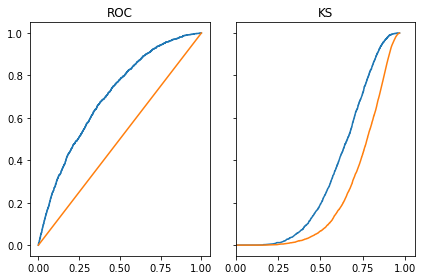

In [14]:
y_proba = GBDT_model_fit.predict_proba(X_test)
fig,(axe1,axe2) = plt.subplots(1,2,sharey = True)
for i in range(len(np.unique(y_test))):
    fpr,tpr,thresholds = roc_curve(y_test,y_proba[:,i],pos_label = i)
axe1.plot(fpr,tpr)
axe1.plot([0,1],[0,1])
axe1.set_title('ROC')
axe2.plot(1 - thresholds,tpr,label = 'TPR')
axe2.plot(1 - thresholds,fpr,label = 'FPR')
plt.xlim(0,)
axe2.set_title('KS')
plt.tight_layout()
plt.show()